In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost.callback import LearningRateScheduler

#from indicators import set_indicators
from XGBoostLearning.dataPreprocess import preprocess

In [401]:
# 1. 加载数据并添加技术指标
print("加载数据...")
data = pd.read_csv("Russell1000AndSP500_withIndicators.csv")
data = preprocess(data)

# 2. 保留时序顺序（真实场景中不打乱）
# 如果需要随机打乱，请取消下面两行注释
# data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 3. 定义特征列
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'RSI', 'WR', 'BB_lower', 'BB_middle', 'BB_upper',
    'MA5', 'MA10', 'MA20', 'MA50', 'MACD', 'Signal', 'Histogram',
    '%K', '%D', '%J', 'ATR', 'OBV', 'ADX', 'DMP', 'DMN',
    'StochRSI_k', 'StochRSI_d', 'CCI'
] + [f'lag_{i}' for i in range(1, 16)]

# 去除缺失数据
data.dropna(subset=features + ['pct_chg'], inplace=True)

# 4. 特征归一化（可选）
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 5. 构造训练集和测试集（保留时序）
X = data[features].astype(np.float32)
y = data['pct_chg'].astype(np.float32)

split = int(0.8 * len(data))  # 80%训练，20%测试
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 创建 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 6. 定义模型参数

加载数据...


In [402]:
params = {
        "max_depth": 7,
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "eval_metric": "rmse",
        "reg_alpha": 0.1,
        "reg_lambda": 0.7,
        "seed": 42,
        "subsample": 0.815,
        "colsample_bytree": 0.89
    }

In [403]:
# 7. 定义学习率衰减函数
# 初始学习率设为 0.4，每 5 轮乘以 0.98 衰减一次
def lr_decay(epoch):
    # if epoch < 300:
    #     lr = 0.65 * (0.95 ** (epoch % 6))
    # elif epoch < 700:
    #     lr = 0.6
    # else:
    #     lr = 0.5
    lr = 0.65 * (0.95 ** (epoch % 6))
    return lr


开始训练...
[0]	train-rmse:19.55167	test-rmse:7.03955
[1]	train-rmse:11.90327	test-rmse:6.52928
[2]	train-rmse:7.71927	test-rmse:6.48559
[3]	train-rmse:5.98363	test-rmse:6.31951
[4]	train-rmse:5.58236	test-rmse:6.17651
[5]	train-rmse:4.37962	test-rmse:6.14723
[6]	train-rmse:3.35836	test-rmse:5.76978
[7]	train-rmse:2.52502	test-rmse:4.97777
[8]	train-rmse:2.20266	test-rmse:4.97169
[9]	train-rmse:2.04124	test-rmse:4.92432
[10]	train-rmse:1.81119	test-rmse:4.87693
[11]	train-rmse:1.67904	test-rmse:4.87341
[12]	train-rmse:1.66062	test-rmse:4.86737
[13]	train-rmse:1.64657	test-rmse:4.79922
[14]	train-rmse:1.55321	test-rmse:4.77152
[15]	train-rmse:1.50299	test-rmse:4.76446
[16]	train-rmse:1.48815	test-rmse:4.76102
[17]	train-rmse:1.46383	test-rmse:4.71651
[18]	train-rmse:1.43781	test-rmse:4.68136
[19]	train-rmse:1.41369	test-rmse:4.66963
[20]	train-rmse:1.40154	test-rmse:4.66857
[21]	train-rmse:1.39027	test-rmse:4.66471
[22]	train-rmse:1.35919	test-rmse:4.67638
[23]	train-rmse:1.35071	test-rmse:

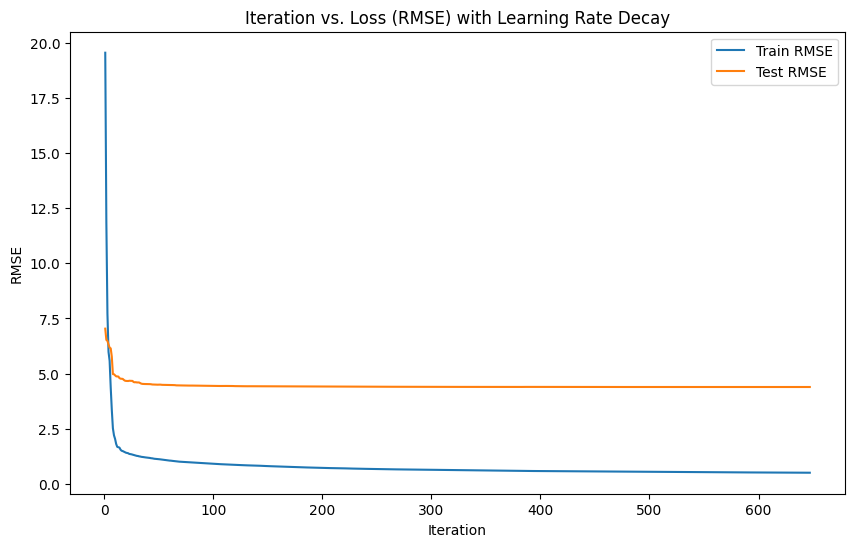

Test MSE: 19.3010
Test MAE: 0.5171


In [404]:
# 8. 训练模型
evals = [(dtrain, "train"), (dtest, "test")]
evals_result = {}  # 用于存储评估结果
print("开始训练...")
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    early_stopping_rounds=100,
    evals=evals,
    evals_result=evals_result,  # 传入一个空字典来记录评估结果
    callbacks=[LearningRateScheduler(lr_decay)]
)

# 9. 绘制损失曲线，直接使用 evals_result 字典
train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']
epochs = list(range(1, len(train_rmse) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_rmse, label='Train RMSE')
plt.plot(epochs, test_rmse, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Iteration vs. Loss (RMSE) with Learning Rate Decay')
plt.legend()
plt.show()

# 10. 模型预测与评估
y_pred = bst.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")